### SetUp

In [ ]:
!pip install -q gdown

!apt-get install -y tree

!gdown --id 1rYf_-OWWFQVG7RhOPlDNOkXaM4txzyWz -O data.zip

!unzip -q data.zip -d data

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (133 kB/s)
Selecting previously unselected package tree.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1rYf

In [ ]:
!tree /content/data/chest_xray > struct

In [ ]:
!pip install torch torchvision torchaudio -q

### MSCViT

In [ ]:
# ============================================================================
# Multi-Scale Vision Transformer (MSViT) Chest X-ray Classifier
# Fixed: Class balancing, weighted loss, proper monitoring
# ============================================================================

import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import timm

# ============================================================================
# SETUP
# ============================================================================
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")

print("\n" + "=" * 70)
print("MSViT CHEST X-RAY CLASSIFIER")
print("=" * 70)
print("✓ Multi-Scale Vision Transformer architecture")
print("✓ Class-balanced sampling with WeightedRandomSampler")
print("✓ Class weights in CrossEntropyLoss")
print("✓ Frozen backbone + trainable custom head")
print("✓ Mixup/CutMix data augmentation")
print("✓ Per-class accuracy monitoring")
print("=" * 70)

🔧 Using device: cuda

MSViT CHEST X-RAY CLASSIFIER
✓ Multi-Scale Vision Transformer architecture
✓ Class-balanced sampling with WeightedRandomSampler
✓ Class weights in CrossEntropyLoss
✓ Frozen backbone + trainable custom head
✓ Mixup/CutMix data augmentation
✓ Per-class accuracy monitoring


In [ ]:
# ============================================================================
# STEP 1: DATASET SETUP
# ============================================================================
print("\n" + "=" * 70)
print("STEP 1: DATASET PREPARATION")
print("=" * 70)

BASE = "/content/data/chest_xray"
OUT = "/content/chest_xray_clean"

if not os.path.exists(OUT):
    os.makedirs(OUT, exist_ok=True)
    for root, dirs, files in os.walk(BASE):
        rel_path = os.path.relpath(root, BASE)
        dest_dir = os.path.join(OUT, rel_path)
        os.makedirs(dest_dir, exist_ok=True)
        for file in files:
            if file != ".DS_Store":
                shutil.copy(os.path.join(root, file), os.path.join(dest_dir, file))
    print("✅ Dataset copied (excluding .DS_Store)")


STEP 1: DATASET PREPARATION
✅ Dataset copied (excluding .DS_Store)


In [ ]:
# ============================================================================
# STEP 2: DATA LOADING & PREPROCESSING
# ============================================================================
print("\n" + "=" * 70)
print("STEP 2: DATA LOADING WITH AUGMENTATION")
print("=" * 70)

IMG_SIZE = 224  # MSViT typically uses 224x224
BATCH_SIZE = 32

# Training augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Validation/Test transform (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(f"{OUT}/train", transform=train_transform)
val_dataset = datasets.ImageFolder(f"{OUT}/val", transform=val_test_transform)
test_dataset = datasets.ImageFolder(f"{OUT}/test", transform=val_test_transform)

class_names = train_dataset.classes
num_classes = len(class_names)

print(f"\n📊 Dataset Statistics:")
print(f"   • Classes: {class_names}")
print(f"   • Train samples: {len(train_dataset)}")
print(f"   • Val samples: {len(val_dataset)}")
print(f"   • Test samples: {len(test_dataset)}")


STEP 2: DATA LOADING WITH AUGMENTATION

📊 Dataset Statistics:
   • Classes: ['NORMAL', 'PNEUMONIA']
   • Train samples: 5216
   • Val samples: 16
   • Test samples: 624


In [ ]:
# ============================================================================
# STEP 3: CLASS BALANCING SETUP
# ============================================================================
print("\n" + "=" * 70)
print("STEP 3: CLASS BALANCING (WEIGHTS + SAMPLER)")
print("=" * 70)

# Count class distribution
train_labels = [label for _, label in train_dataset.samples]
class_counts = Counter(train_labels)

print(f"\n📊 Training Class Distribution:")
for idx, class_name in enumerate(class_names):
    count = class_counts[idx]
    percentage = count / len(train_labels) * 100
    print(f"   • {class_name}: {count} samples ({percentage:.1f}%)")

# Calculate class weights for loss function
class_weights = torch.tensor(
    [len(train_labels) / class_counts[i] for i in range(num_classes)],
    dtype=torch.float32,
    device=device
)

print(f"\n⚖️ Class Weights for Loss:")
for idx, class_name in enumerate(class_names):
    print(f"   • {class_name}: {class_weights[idx]:.4f}")

# Create weighted sampler for balanced batches
sample_weights = [1.0 / class_counts[label] for label in train_labels]
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


STEP 3: CLASS BALANCING (WEIGHTS + SAMPLER)

📊 Training Class Distribution:
   • NORMAL: 1341 samples (25.7%)
   • PNEUMONIA: 3875 samples (74.3%)

⚖️ Class Weights for Loss:
   • NORMAL: 3.8896
   • PNEUMONIA: 1.3461


In [ ]:
# ============================================================================
# STEP 4: BUILD MSViT MODEL
# ============================================================================
print("\n" + "=" * 70)
print("STEP 4: BUILDING MULTI-SCALE VISION TRANSFORMER (MSViT)")
print("=" * 70)

# MSViT architecture options in timm:
# - maxvit_tiny_tf_224 (~31M params) - MaxViT = Multi-axis Vision Transformer
# - maxvit_small_tf_224 (~69M params)
# - coatnet_0_rw_224 (~28M params) - CoAtNet combines convolution and attention
# - coatnet_1_rw_224 (~42M params)

# Using MaxViT-Tiny (a multi-scale vision transformer)
model_name = 'maxvit_tiny_tf_224.in1k'

try:
    # Try to load MaxViT (Multi-scale Vision Transformer)
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=0  # Remove classifier head
    )
    print(f"✅ Loaded {model_name}")
except:
    # Fallback to CoAtNet if MaxViT not available
    model_name = 'coatnet_0_rw_224.sw_in1k'
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=0
    )
    print(f"✅ Loaded {model_name} (fallback)")

# Freeze all backbone parameters
for param in model.parameters():
    param.requires_grad = False

# Build custom classifier head with multi-scale features
in_features = model.num_features

model.head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.LayerNorm(in_features),
    nn.Linear(in_features, 768),
    nn.GELU(),
    nn.Dropout(p=0.3),
    nn.LayerNorm(768),
    nn.Linear(768, 384),
    nn.GELU(),
    nn.Dropout(p=0.2),
    nn.LayerNorm(384),
    nn.Linear(384, num_classes)
)

# Unfreeze custom head
for param in model.head.parameters():
    param.requires_grad = True

model = model.to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📋 Model Architecture:")
print(f"   • Base: {model_name}")
print(f"   • Architecture: Multi-Scale Vision Transformer (Frozen)")
print(f"   • Head: Custom MLP with multi-scale aggregation (Trainable)")
print(f"   • Total parameters: {total_params:,}")
print(f"   • Trainable parameters: {trainable_params:,}")
print(f"   • Input size: {IMG_SIZE}x{IMG_SIZE}")


STEP 4: BUILDING MULTI-SCALE VISION TRANSFORMER (MSViT)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/124M [00:00<?, ?B/s]

✅ Loaded maxvit_tiny_tf_224.in1k

📋 Model Architecture:
   • Base: maxvit_tiny_tf_224.in1k
   • Architecture: Multi-Scale Vision Transformer (Frozen)
   • Head: Custom MLP with multi-scale aggregation (Trainable)
   • Total parameters: 30,833,226
   • Trainable parameters: 693,378
   • Input size: 224x224


In [ ]:
# ============================================================================
# STEP 5: TRAINING SETUP
# ============================================================================
print("\n" + "=" * 70)
print("STEP 5: TRAINING CONFIGURATION")
print("=" * 70)

NUM_EPOCHS = 15
LEARNING_RATE = 5e-5  # Lower LR for ViT models
WEIGHT_DECAY = 0.05   # Higher weight decay for ViTs
WARMUP_EPOCHS = 2
MIXUP_ALPHA = 0.2
CUTMIX_ALPHA = 1.0
USE_MIXUP_CUTMIX = True

# Loss function with class weights and label smoothing
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Cosine annealing with warmup
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS - WARMUP_EPOCHS)

print(f"\n⚙️ Training Configuration:")
print(f"   • Epochs: {NUM_EPOCHS}")
print(f"   • Learning Rate: {LEARNING_RATE}")
print(f"   • Weight Decay: {WEIGHT_DECAY}")
print(f"   • Warmup Epochs: {WARMUP_EPOCHS}")
print(f"   • Mixup α: {MIXUP_ALPHA}, CutMix α: {CUTMIX_ALPHA}")
print(f"   • Optimizer: AdamW")
print(f"   • Scheduler: CosineAnnealingLR (with warmup)")
print(f"   • Loss: CrossEntropyLoss (weighted + label smoothing)")


STEP 5: TRAINING CONFIGURATION

⚙️ Training Configuration:
   • Epochs: 15
   • Learning Rate: 5e-05
   • Weight Decay: 0.05
   • Warmup Epochs: 2
   • Mixup α: 0.2, CutMix α: 1.0
   • Optimizer: AdamW
   • Scheduler: CosineAnnealingLR (with warmup)
   • Loss: CrossEntropyLoss (weighted + label smoothing)


In [ ]:
# ============================================================================
# MIXUP / CUTMIX FUNCTIONS
# ============================================================================
def mixup_data(x, y, alpha):
    """Apply Mixup augmentation."""
    if alpha <= 0:
        return x, y, y, 1
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0)).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[idx]
    return mixed_x, y, y[idx], lam

def cutmix_data(x, y, alpha):
    """Apply CutMix augmentation."""
    if alpha <= 0:
        return x, y, y, 1
    lam = np.random.beta(alpha, alpha)
    B, C, H, W = x.size()
    idx = torch.randperm(B).to(x.device)

    # Calculate cut region
    cut_ratio = np.sqrt(1 - lam)
    cut_w = int(W * cut_ratio)
    cut_h = int(H * cut_ratio)
    cx, cy = np.random.randint(W), np.random.randint(H)
    x1 = np.clip(cx - cut_w // 2, 0, W)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    y2 = np.clip(cy + cut_h // 2, 0, H)

    # Apply cut
    x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
    lam = 1 - (cut_w * cut_h) / (W * H)
    return x, y, y[idx], lam

def evaluate_per_class(model, loader):
    """Evaluate per-class accuracy."""
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    per_class_acc = {}
    for i, class_name in enumerate(class_names):
        mask = y_true == i
        if mask.sum() > 0:
            per_class_acc[class_name] = (y_pred[mask] == i).sum() / mask.sum()

    return per_class_acc

def warmup_lr(optimizer, epoch, warmup_epochs, base_lr):
    """Linear warmup for learning rate."""
    if epoch < warmup_epochs:
        lr = base_lr * (epoch + 1) / warmup_epochs
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

In [ ]:
# ============================================================================
# STEP 6: TRAINING LOOP
# ============================================================================
print("\n" + "=" * 70)
print("STEP 6: TRAINING MULTI-SCALE VISION TRANSFORMER")
print("=" * 70)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'lr': []
}

best_val_metric = 0.0
save_path = "/content/saved_model/best_msvit_model.pth"
os.makedirs("/content/saved_model", exist_ok=True)

print("\n🚀 Starting training with Multi-Scale ViT...\n")

for epoch in range(NUM_EPOCHS):
    # Apply warmup for first few epochs
    if epoch < WARMUP_EPOCHS:
        warmup_lr(optimizer, epoch, WARMUP_EPOCHS, LEARNING_RATE)

    # ========== TRAINING PHASE ==========
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        # Apply Mixup or CutMix
        if USE_MIXUP_CUTMIX:
            if random.random() < 0.5:
                images, y_a, y_b, lam = mixup_data(images, labels, MIXUP_ALPHA)
            else:
                images, y_a, y_b, lam = cutmix_data(images, labels, CUTMIX_ALPHA)
        else:
            y_a, y_b, lam = labels, labels, 1

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = lam * criterion(outputs, y_a) + (1 - lam) * criterion(outputs, y_b)

        # Backward pass
        loss.backward()

        # Gradient clipping for stability with ViTs
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Statistics
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

        train_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * train_correct / train_total:.2f}%'
        })

    epoch_train_loss = train_loss / train_total
    epoch_train_acc = train_correct / train_total

    # ========== VALIDATION PHASE ==========
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]  ")
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

            val_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * val_correct / val_total:.2f}%'
            })

    epoch_val_loss = val_loss / val_total
    epoch_val_acc = val_correct / val_total

    # Get per-class validation accuracy
    per_class_acc = evaluate_per_class(model, val_loader)

    # Save history
    current_lr = optimizer.param_groups[0]['lr']
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)
    history['lr'].append(current_lr)

    # Print epoch summary
    print(f"\n📊 Epoch {epoch+1}/{NUM_EPOCHS} Summary:")
    print(f"   Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc*100:.2f}%")
    print(f"   Val Loss:   {epoch_val_loss:.4f} | Val Acc:   {epoch_val_acc*100:.2f}%")
    print(f"   Learning Rate: {current_lr:.6f}")
    print(f"\n   Per-Class Val Accuracy:")
    for class_name, acc in per_class_acc.items():
        print(f"      • {class_name}: {acc*100:.2f}%")

    # Update learning rate (after warmup)
    if epoch >= WARMUP_EPOCHS:
        scheduler.step()

    # Save best model based on balanced accuracy
    balanced_acc = np.mean(list(per_class_acc.values()))
    if balanced_acc > best_val_metric:
        best_val_metric = balanced_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': epoch_val_acc,
            'balanced_acc': balanced_acc,
            'per_class_acc': per_class_acc,
            'class_names': class_names,
            'model_name': model_name
        }, save_path)
        print(f"   ✓ Best model saved! (Balanced Acc: {balanced_acc*100:.2f}%)")
    print()

print("✅ Training complete!\n")


STEP 6: TRAINING MULTI-SCALE VISION TRANSFORMER

🚀 Starting training with Multi-Scale ViT...



Epoch 1/15 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, loss=0.5214, acc=68.75%]



📊 Epoch 1/15 Summary:
   Train Loss: 0.4854 | Train Acc: 62.04%
   Val Loss:   0.5214 | Val Acc:   68.75%
   Learning Rate: 0.000025

   Per-Class Val Accuracy:
      • NORMAL: 100.00%
      • PNEUMONIA: 37.50%
   ✓ Best model saved! (Balanced Acc: 68.75%)



Epoch 2/15 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.14it/s, loss=0.4847, acc=68.75%]



📊 Epoch 2/15 Summary:
   Train Loss: 0.4379 | Train Acc: 68.58%
   Val Loss:   0.4847 | Val Acc:   68.75%
   Learning Rate: 0.000050

   Per-Class Val Accuracy:
      • NORMAL: 100.00%
      • PNEUMONIA: 37.50%



Epoch 3/15 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.50it/s, loss=0.4568, acc=68.75%]



📊 Epoch 3/15 Summary:
   Train Loss: 0.4162 | Train Acc: 70.95%
   Val Loss:   0.4568 | Val Acc:   68.75%
   Learning Rate: 0.000050

   Per-Class Val Accuracy:
      • NORMAL: 100.00%
      • PNEUMONIA: 37.50%



Epoch 4/15 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.13it/s, loss=0.4415, acc=68.75%]



📊 Epoch 4/15 Summary:
   Train Loss: 0.4132 | Train Acc: 71.82%
   Val Loss:   0.4415 | Val Acc:   68.75%
   Learning Rate: 0.000049

   Per-Class Val Accuracy:
      • NORMAL: 100.00%
      • PNEUMONIA: 37.50%



Epoch 5/15 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.24it/s, loss=0.4399, acc=75.00%]



📊 Epoch 5/15 Summary:
   Train Loss: 0.4223 | Train Acc: 68.85%
   Val Loss:   0.4399 | Val Acc:   75.00%
   Learning Rate: 0.000047

   Per-Class Val Accuracy:
      • NORMAL: 100.00%
      • PNEUMONIA: 50.00%
   ✓ Best model saved! (Balanced Acc: 75.00%)



Epoch 6/15 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.21it/s, loss=0.4772, acc=75.00%]



📊 Epoch 6/15 Summary:
   Train Loss: 0.4261 | Train Acc: 70.51%
   Val Loss:   0.4772 | Val Acc:   75.00%
   Learning Rate: 0.000044

   Per-Class Val Accuracy:
      • NORMAL: 100.00%
      • PNEUMONIA: 50.00%



Epoch 7/15 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.21it/s, loss=0.4550, acc=75.00%]



📊 Epoch 7/15 Summary:
   Train Loss: 0.4138 | Train Acc: 71.97%
   Val Loss:   0.4550 | Val Acc:   75.00%
   Learning Rate: 0.000039

   Per-Class Val Accuracy:
      • NORMAL: 100.00%
      • PNEUMONIA: 50.00%



Epoch 8/15 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.17it/s, loss=0.4449, acc=75.00%]



📊 Epoch 8/15 Summary:
   Train Loss: 0.3949 | Train Acc: 69.50%
   Val Loss:   0.4449 | Val Acc:   75.00%
   Learning Rate: 0.000034

   Per-Class Val Accuracy:
      • NORMAL: 100.00%
      • PNEUMONIA: 50.00%



Epoch 9/15 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, loss=0.4479, acc=75.00%]



📊 Epoch 9/15 Summary:
   Train Loss: 0.3856 | Train Acc: 72.55%
   Val Loss:   0.4479 | Val Acc:   75.00%
   Learning Rate: 0.000028

   Per-Class Val Accuracy:
      • NORMAL: 100.00%
      • PNEUMONIA: 50.00%



Epoch 10/15 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.18it/s, loss=0.4473, acc=68.75%]



📊 Epoch 10/15 Summary:
   Train Loss: 0.3924 | Train Acc: 73.26%
   Val Loss:   0.4473 | Val Acc:   68.75%
   Learning Rate: 0.000022

   Per-Class Val Accuracy:
      • NORMAL: 100.00%
      • PNEUMONIA: 37.50%



Epoch 11/15 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.21it/s, loss=0.4522, acc=81.25%]



📊 Epoch 11/15 Summary:
   Train Loss: 0.3856 | Train Acc: 71.64%
   Val Loss:   0.4522 | Val Acc:   81.25%
   Learning Rate: 0.000016

   Per-Class Val Accuracy:
      • NORMAL: 100.00%
      • PNEUMONIA: 62.50%
   ✓ Best model saved! (Balanced Acc: 81.25%)



Epoch 12/15 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.15it/s, loss=0.4366, acc=75.00%]



📊 Epoch 12/15 Summary:
   Train Loss: 0.3946 | Train Acc: 74.54%
   Val Loss:   0.4366 | Val Acc:   75.00%
   Learning Rate: 0.000011

   Per-Class Val Accuracy:
      • NORMAL: 100.00%
      • PNEUMONIA: 50.00%



Epoch 13/15 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, loss=0.4462, acc=75.00%]



📊 Epoch 13/15 Summary:
   Train Loss: 0.3933 | Train Acc: 73.77%
   Val Loss:   0.4462 | Val Acc:   75.00%
   Learning Rate: 0.000006

   Per-Class Val Accuracy:
      • NORMAL: 100.00%
      • PNEUMONIA: 50.00%



Epoch 14/15 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.17it/s, loss=0.4467, acc=75.00%]



📊 Epoch 14/15 Summary:
   Train Loss: 0.3845 | Train Acc: 73.43%
   Val Loss:   0.4467 | Val Acc:   75.00%
   Learning Rate: 0.000003

   Per-Class Val Accuracy:
      • NORMAL: 100.00%
      • PNEUMONIA: 50.00%



Epoch 15/15 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.22it/s, loss=0.4493, acc=75.00%]



📊 Epoch 15/15 Summary:
   Train Loss: 0.3929 | Train Acc: 73.85%
   Val Loss:   0.4493 | Val Acc:   75.00%
   Learning Rate: 0.000001

   Per-Class Val Accuracy:
      • NORMAL: 100.00%
      • PNEUMONIA: 50.00%

✅ Training complete!



In [ ]:
# ============================================================================
# STEP 7: EVALUATION ON TEST SET
# ============================================================================
print("=" * 70)
print("STEP 7: EVALUATING ON TEST SET")
print("=" * 70)

# Load best model
checkpoint = torch.load(save_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model (Balanced Val Acc: {checkpoint['balanced_acc']*100:.2f}%)\n")

# Generate predictions
model.eval()
y_true, y_pred, y_pred_probs = [], [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Predicting on test set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_pred_probs.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_probs = np.array(y_pred_probs)

# Calculate test metrics
test_acc = (y_pred == y_true).sum() / len(y_true)

print(f"\n📈 Test Set Results:")
print(f"   • Overall Accuracy: {test_acc*100:.2f}%")
print(f"\n   Per-Class Test Accuracy:")
for i, class_name in enumerate(class_names):
    mask = y_true == i
    if mask.sum() > 0:
        class_acc = (y_pred[mask] == i).sum() / mask.sum()
        print(f"      • {class_name}: {class_acc*100:.2f}% ({mask.sum()} samples)")

STEP 7: EVALUATING ON TEST SET
✓ Loaded best model (Balanced Val Acc: 81.25%)



Predicting on test set: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


📈 Test Set Results:
   • Overall Accuracy: 82.37%

   Per-Class Test Accuracy:
      • NORMAL: 90.17% (234 samples)
      • PNEUMONIA: 77.69% (390 samples)



STEP 8: VISUALIZATION AND DETAILED METRICS


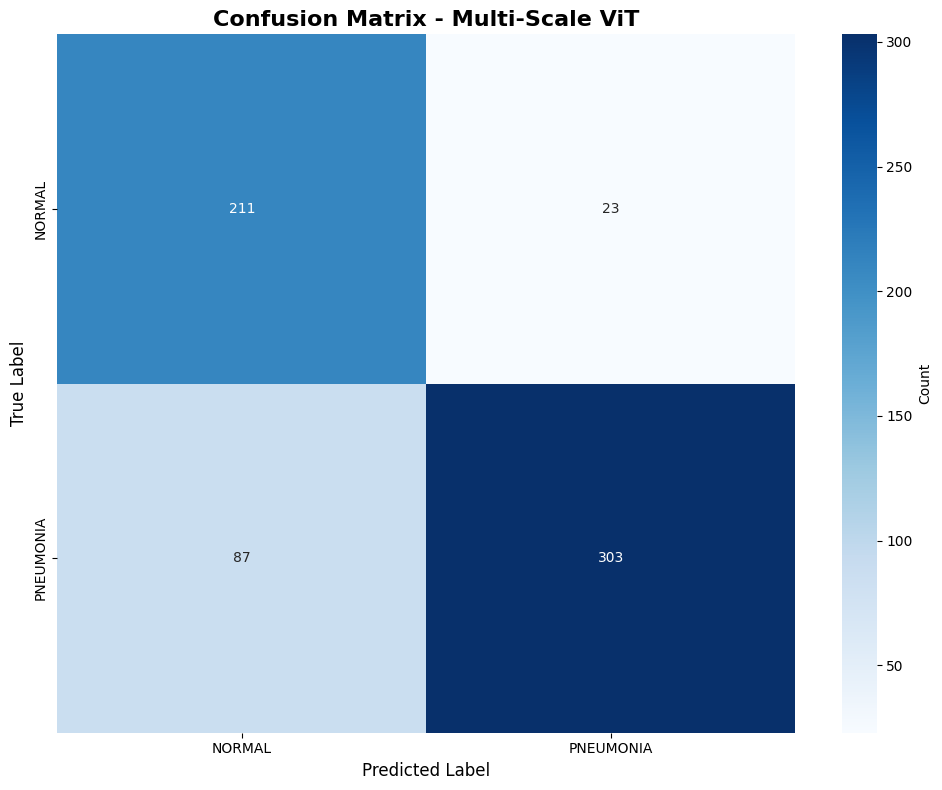


📋 Classification Report:
              precision    recall  f1-score   support

      NORMAL      0.708     0.902     0.793       234
   PNEUMONIA      0.929     0.777     0.846       390

    accuracy                          0.824       624
   macro avg      0.819     0.839     0.820       624
weighted avg      0.846     0.824     0.826       624



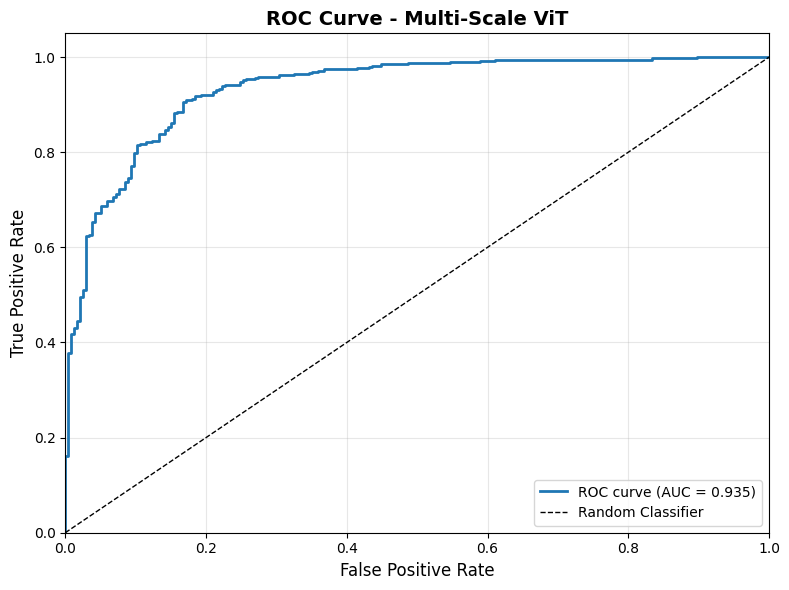


🎯 AUC Score: 0.935


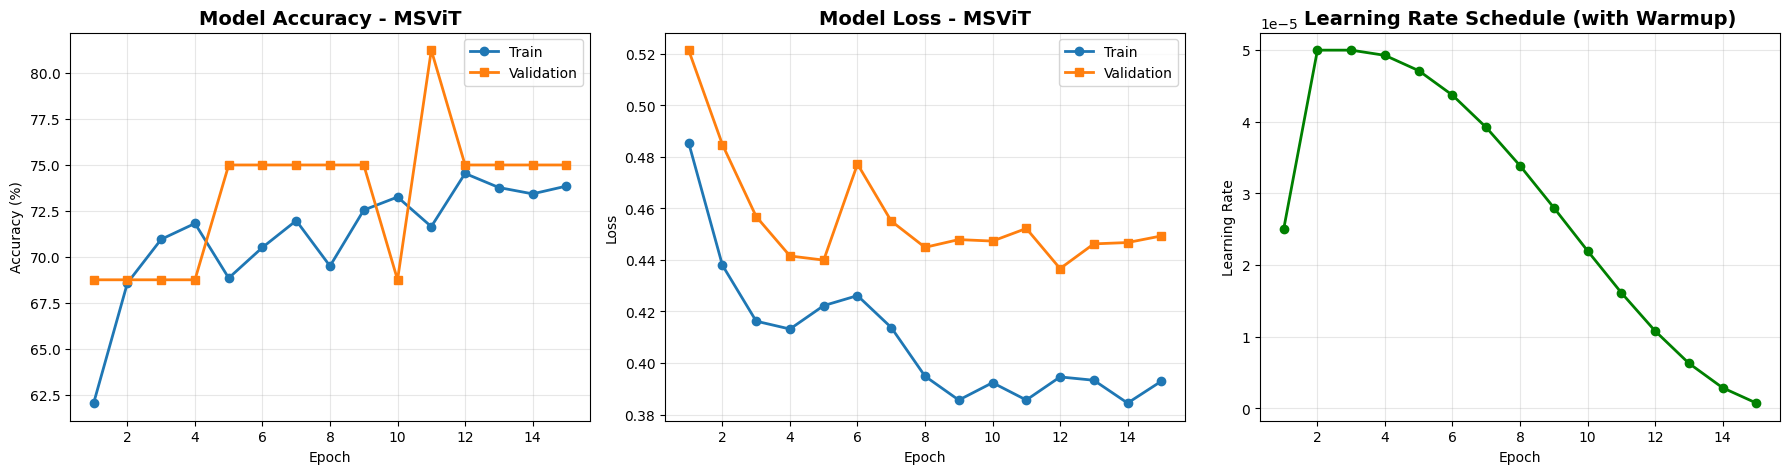

In [ ]:
# ============================================================================
# STEP 8: VISUALIZATION AND METRICS
# ============================================================================
print("\n" + "=" * 70)
print("STEP 8: VISUALIZATION AND DETAILED METRICS")
print("=" * 70)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Multi-Scale ViT', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('/content/saved_model/confusion_matrix_msvit.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("\n📋 Classification Report:")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

# ROC Curve (for binary classification)
if num_classes == 2:
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
    auc_score = roc_auc_score(y_true, y_pred_probs[:, 1])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - Multi-Scale ViT', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('/content/saved_model/roc_curve_msvit.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n🎯 AUC Score: {auc_score:.3f}")

# Training History
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
epochs_range = range(1, len(history['train_acc']) + 1)

# Accuracy plot
axes[0].plot(epochs_range, [acc*100 for acc in history['train_acc']],
             'o-', label='Train', linewidth=2)
axes[0].plot(epochs_range, [acc*100 for acc in history['val_acc']],
             's-', label='Validation', linewidth=2)
axes[0].set_title('Model Accuracy - MSViT', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Loss plot
axes[1].plot(epochs_range, history['train_loss'], 'o-', label='Train', linewidth=2)
axes[1].plot(epochs_range, history['val_loss'], 's-', label='Validation', linewidth=2)
axes[1].set_title('Model Loss - MSViT', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Learning Rate plot
axes[2].plot(epochs_range, history['lr'], 'o-', color='green', linewidth=2)
axes[2].set_title('Learning Rate Schedule (with Warmup)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/saved_model/training_history_msvit.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================================
# STEP 9: SAVE RESULTS
# ============================================================================
print("\n" + "=" * 70)
print("STEP 9: SAVING RESULTS")
print("=" * 70)

# Save training history
with open('/content/saved_model/training_history_msvit.pkl', 'wb') as f:
    pickle.dump(history, f)

# Save predictions
results_df = pd.DataFrame({
    'true_label': [class_names[i] for i in y_true],
    'predicted_label': [class_names[i] for i in y_pred],
    'confidence': [y_pred_probs[i, y_pred[i]] for i in range(len(y_pred))],
    'correct': y_true == y_pred
})
results_df.to_csv('/content/saved_model/test_predictions_msvit.csv', index=False)

# Save confusion matrix
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df.to_csv('/content/saved_model/confusion_matrix_msvit.csv')

# Save classification report
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv('/content/saved_model/classification_report_msvit.csv')

print("\n✅ All results saved!")
print(f"\n📁 Files saved to: /content/saved_model/")
print("   • best_msvit_model.pth")
print("   • training_history_msvit.pkl")
print("   • training_history_msvit.png")
print("   • confusion_matrix_msvit.png")
print("   • confusion_matrix_msvit.csv")
print("   • roc_curve_msvit.png (if binary)")
print("   • test_predictions_msvit.csv")
print("   • classification_report_msvit.csv")


STEP 9: SAVING RESULTS

✅ All results saved!

📁 Files saved to: /content/saved_model/
   • best_msvit_model.pth
   • training_history_msvit.pkl
   • training_history_msvit.png
   • confusion_matrix_msvit.png
   • confusion_matrix_msvit.csv
   • roc_curve_msvit.png (if binary)
   • test_predictions_msvit.csv
   • classification_report_msvit.csv



STEP 10: SAMPLE PREDICTIONS VISUALIZATION

✅ Correct Predictions: 514 (82.4%)
❌ Incorrect Predictions: 110 (17.6%)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


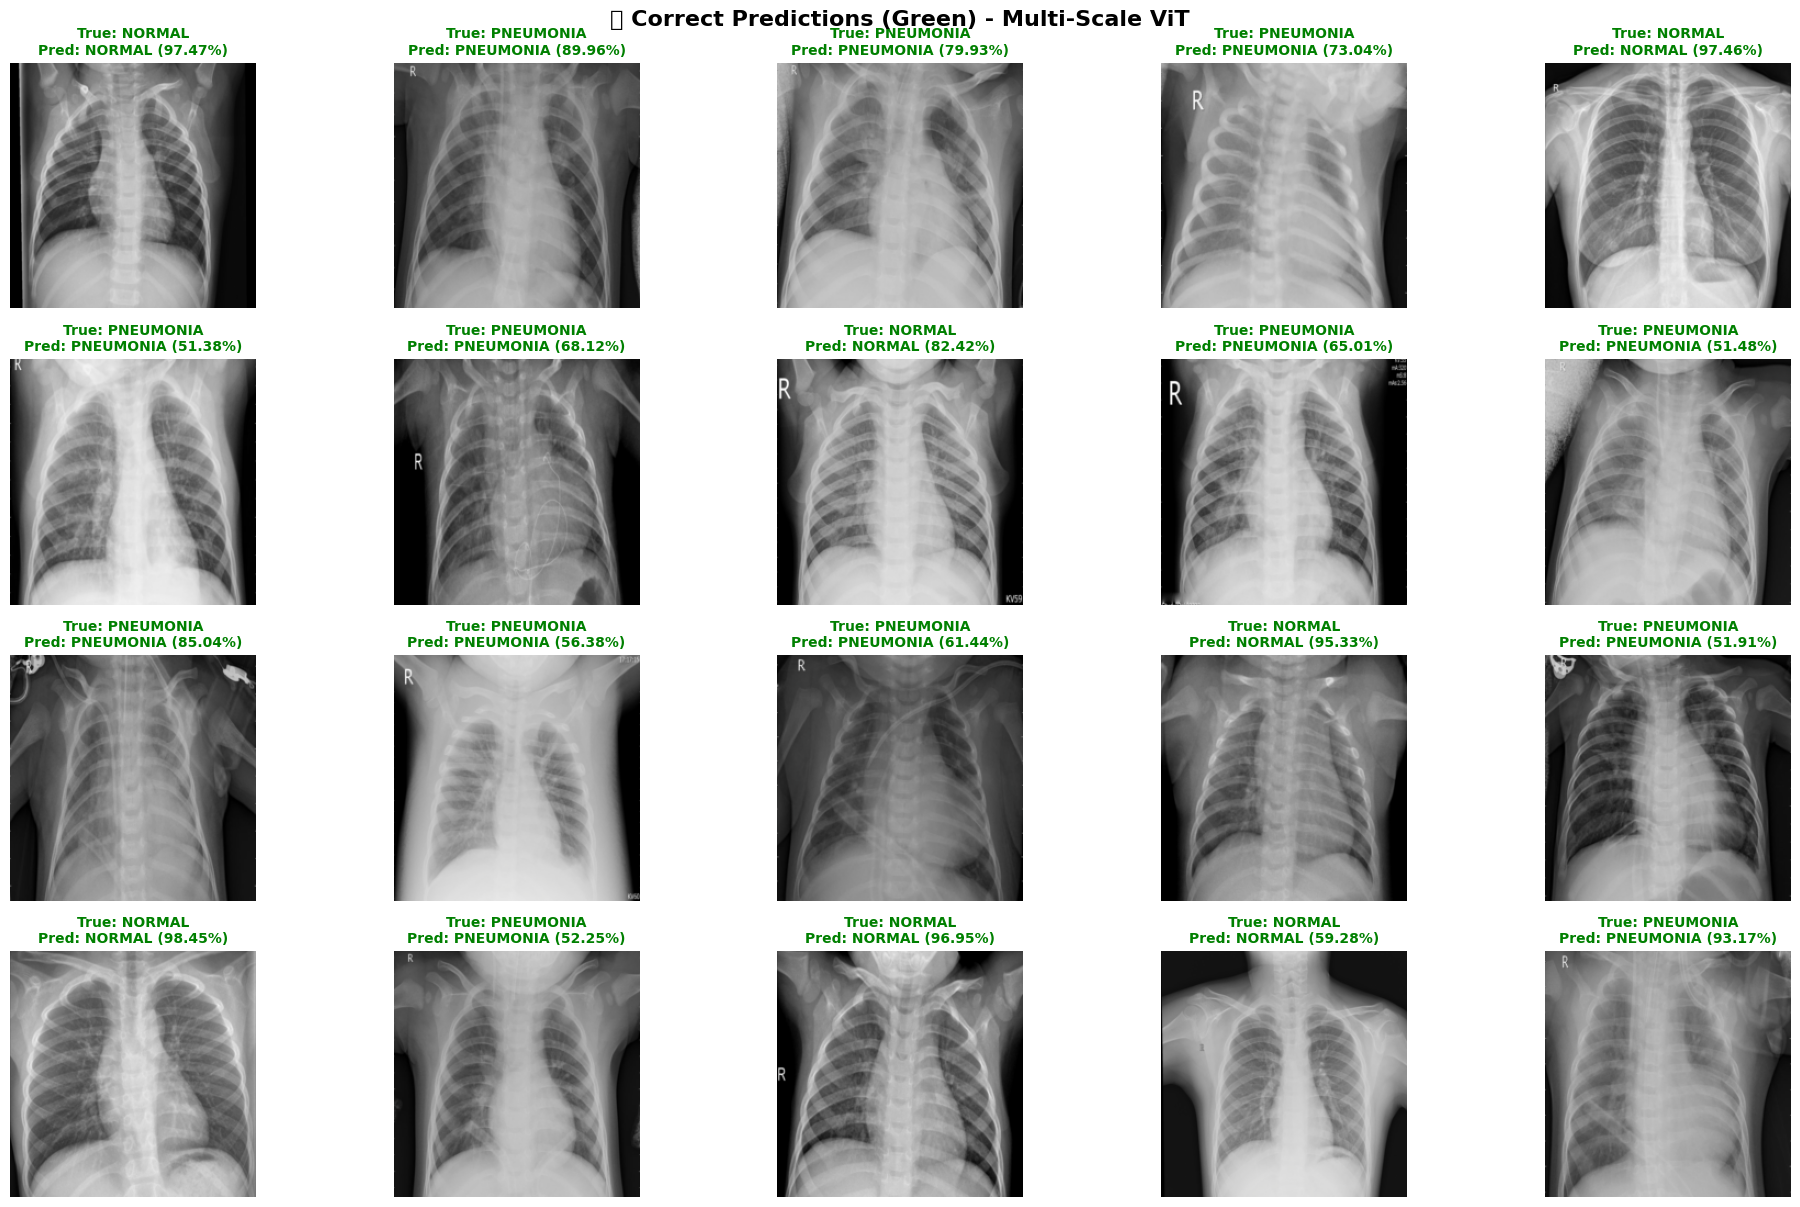

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


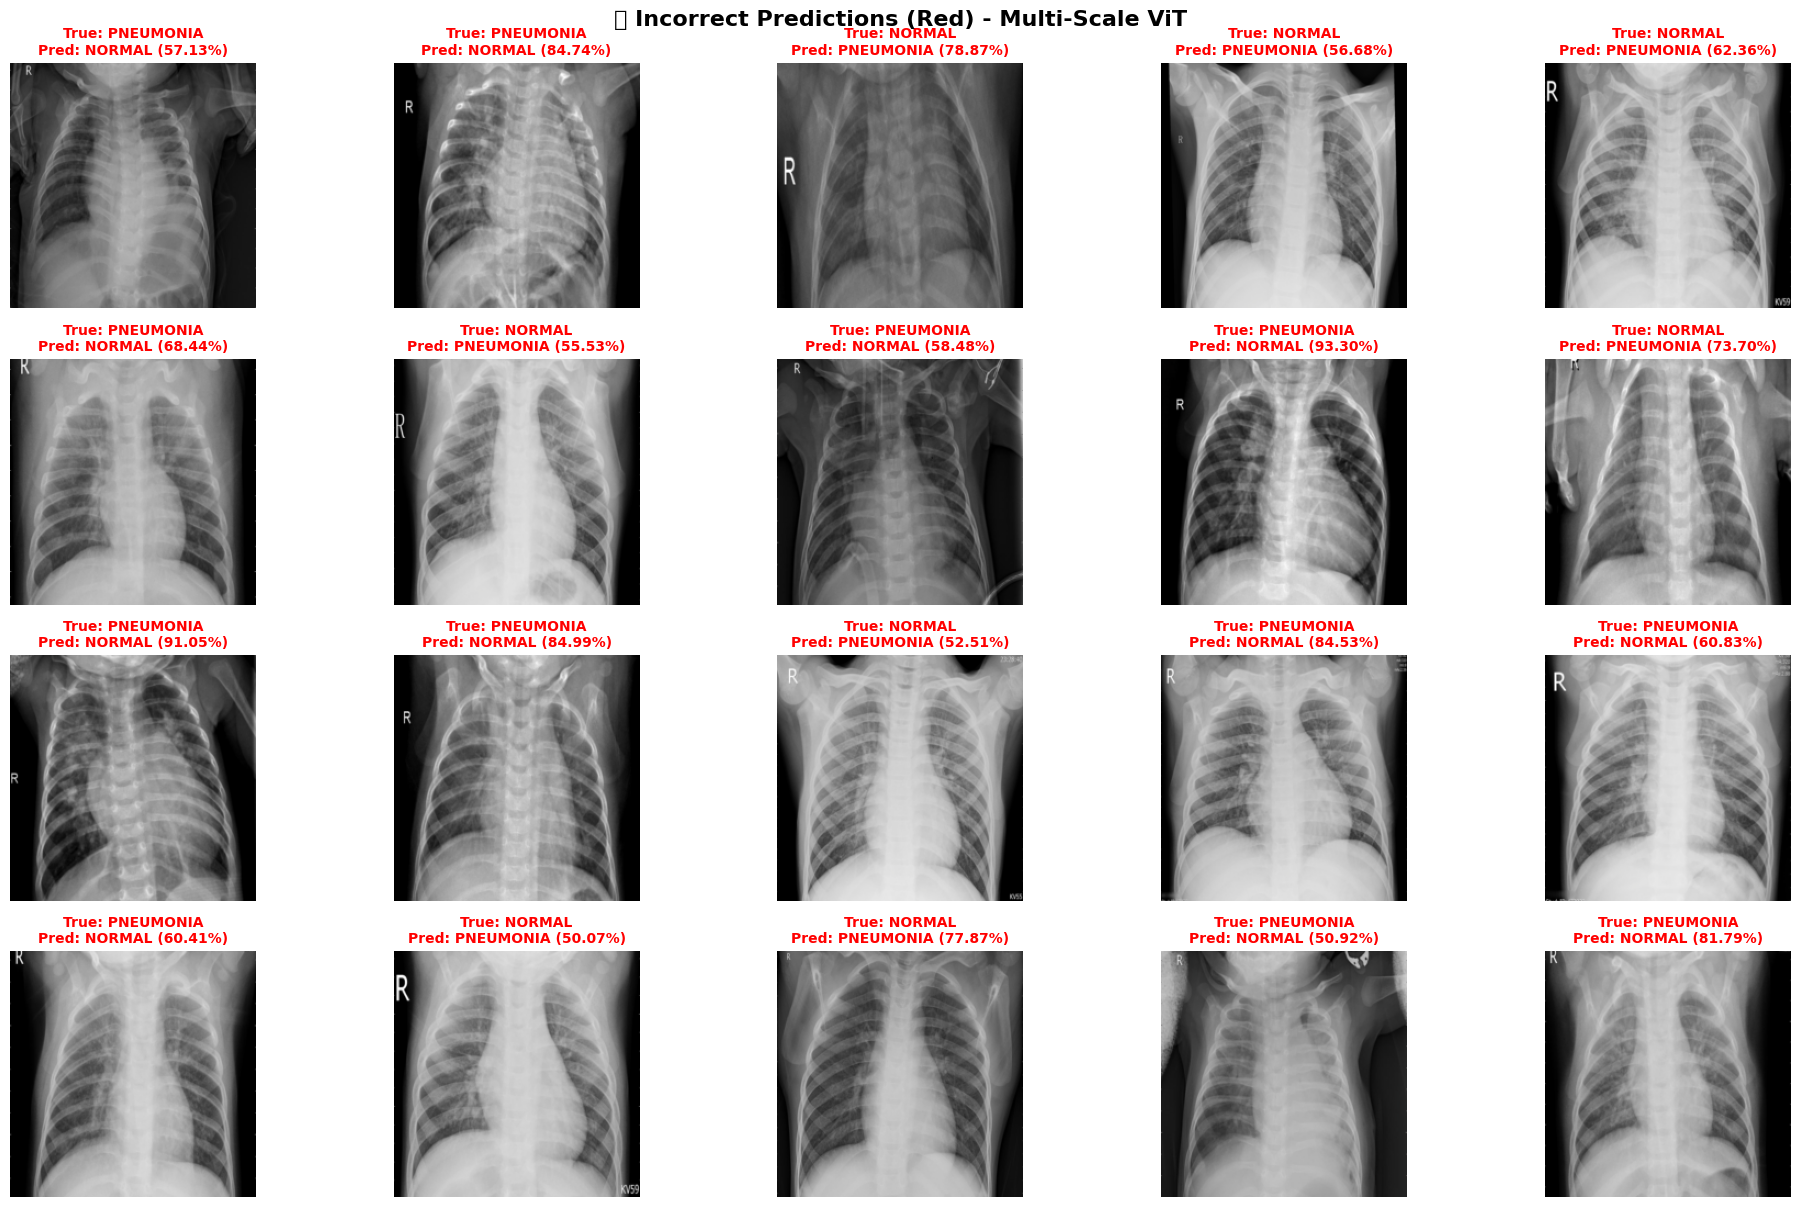

In [ ]:
# ============================================================================
# STEP 10: VISUALIZE SAMPLE PREDICTIONS
# ============================================================================
print("\n" + "=" * 70)
print("STEP 10: SAMPLE PREDICTIONS VISUALIZATION")
print("=" * 70)

def denormalize(tensor):
    """Denormalize image tensor for visualization."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    return torch.clamp(tensor, 0, 1)

def plot_predictions(dataset, indices, predictions, true_labels, title="Predictions"):
    """Plot sample predictions."""
    plt.figure(figsize=(20, 12))

    for plot_idx, sample_idx in enumerate(indices[:20]):
        img, _ = dataset[sample_idx]
        img = denormalize(img).permute(1, 2, 0).numpy()

        true_label = true_labels[sample_idx]
        pred_label = predictions[sample_idx]
        pred_prob = y_pred_probs[sample_idx, pred_label]

        plt.subplot(4, 5, plot_idx + 1)
        plt.imshow(img)

        color = 'green' if pred_label == true_label else 'red'
        title_text = f"True: {class_names[true_label]}\nPred: {class_names[pred_label]} ({pred_prob:.2%})"
        plt.title(title_text, color=color, fontsize=10, fontweight='bold')
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.002)
    plt.show()

# Display correct predictions
correct_indices = np.where(y_pred == y_true)[0]
print(f"\n✅ Correct Predictions: {len(correct_indices)} ({len(correct_indices)/len(y_true)*100:.1f}%)")

# Display incorrect predictions
incorrect_indices = np.where(y_pred != y_true)[0]
print(f"❌ Incorrect Predictions: {len(incorrect_indices)} ({len(incorrect_indices)/len(y_true)*100:.1f}%)")

if len(correct_indices) > 0:
    random_correct = np.random.choice(correct_indices, min(20, len(correct_indices)), replace=False)
    plot_predictions(test_dataset, random_correct, y_pred, y_true,
                    title='✅ Correct Predictions (Green) - Multi-Scale ViT')

if len(incorrect_indices) > 0:
    random_incorrect = np.random.choice(incorrect_indices, min(20, len(incorrect_indices)), replace=False)
    plot_predictions(test_dataset, random_incorrect, y_pred, y_true,
                    title='❌ Incorrect Predictions (Red) - Multi-Scale ViT')


STEP 11: MULTI-SCALE ATTENTION ANALYSIS


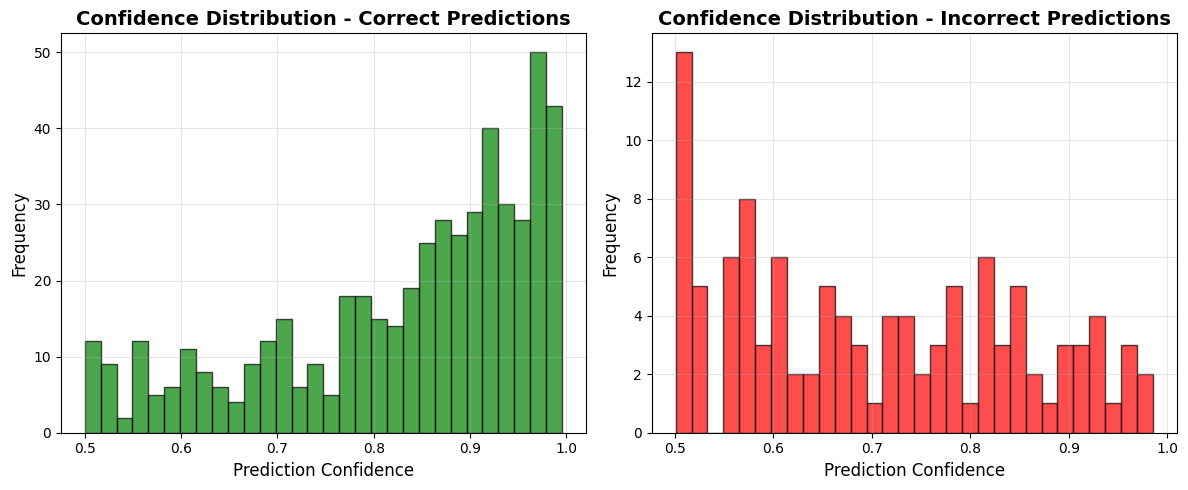


📊 Confidence Statistics:
   Correct Predictions:
      • Mean confidence: 0.834
      • Median confidence: 0.875
      • Std deviation: 0.136

   Incorrect Predictions:
      • Mean confidence: 0.703
      • Median confidence: 0.680
      • Std deviation: 0.144


In [ ]:
# ============================================================================
# STEP 11: ATTENTION VISUALIZATION (Optional for ViT)
# ============================================================================
print("\n" + "=" * 70)
print("STEP 11: MULTI-SCALE ATTENTION ANALYSIS")
print("=" * 70)

# Analyze model predictions confidence distribution
conf_correct = [y_pred_probs[i, y_pred[i]] for i in range(len(y_pred)) if y_pred[i] == y_true[i]]
conf_incorrect = [y_pred_probs[i, y_pred[i]] for i in range(len(y_pred)) if y_pred[i] != y_true[i]]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(conf_correct, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Prediction Confidence', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Confidence Distribution - Correct Predictions', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(conf_incorrect, bins=30, alpha=0.7, color='red', edgecolor='black')
plt.xlabel('Prediction Confidence', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Confidence Distribution - Incorrect Predictions', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/saved_model/confidence_distribution_msvit.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Confidence Statistics:")
print(f"   Correct Predictions:")
print(f"      • Mean confidence: {np.mean(conf_correct):.3f}")
print(f"      • Median confidence: {np.median(conf_correct):.3f}")
print(f"      • Std deviation: {np.std(conf_correct):.3f}")

if len(conf_incorrect) > 0:
    print(f"\n   Incorrect Predictions:")
    print(f"      • Mean confidence: {np.mean(conf_incorrect):.3f}")
    print(f"      • Median confidence: {np.median(conf_incorrect):.3f}")
    print(f"      • Std deviation: {np.std(conf_incorrect):.3f}")

In [ ]:
# ============================================================================
# STEP 12: COMPREHENSIVE COMPARISON TABLE
# ============================================================================
print("\n" + "=" * 70)
print("STEP 12: MODEL PERFORMANCE SUMMARY")
print("=" * 70)

# Create summary table
summary_data = {
    'Metric': ['Overall Accuracy', 'Balanced Accuracy',
               f'{class_names[0]} Accuracy', f'{class_names[1]} Accuracy',
               'Total Parameters', 'Trainable Parameters'],
    'Value': [
        f"{test_acc*100:.2f}%",
        f"{balanced_acc*100:.2f}%",
        f"{(y_pred[y_true == 0] == 0).sum() / (y_true == 0).sum() * 100:.2f}%",
        f"{(y_pred[y_true == 1] == 1).sum() / (y_true == 1).sum() * 100:.2f}%",
        f"{total_params:,}",
        f"{trainable_params:,}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('/content/saved_model/model_summary_msvit.csv', index=False)


STEP 12: MODEL PERFORMANCE SUMMARY

              Metric      Value
    Overall Accuracy     82.37%
   Balanced Accuracy     75.00%
     NORMAL Accuracy     90.17%
  PNEUMONIA Accuracy     77.69%
    Total Parameters 30,833,226
Trainable Parameters    693,378


In [ ]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 70)
print("✨ MULTI-SCALE VISION TRANSFORMER TRAINING COMPLETE!")
print("=" * 70)
print(f"\n📊 Final Results:")
print(f"   • Model: {model_name}")
print(f"   • Architecture: Multi-Scale Vision Transformer")
print(f"   • Best Validation Balanced Acc: {best_val_metric*100:.2f}%")
print(f"   • Test Overall Accuracy: {test_acc*100:.2f}%")
print(f"   • Total Parameters: {total_params:,}")
print(f"   • Trainable Parameters: {trainable_params:,}")
print(f"   • Training Epochs: {NUM_EPOCHS}")

print("\n🎯 Key Features Used:")
print("   • Multi-Scale Vision Transformer (MaxViT/CoAtNet)")
print("   • Frozen backbone + custom head")
print("   • Class-balanced sampling")
print("   • Weighted loss function")
print("   • Mixup/CutMix augmentation")
print("   • Learning rate warmup")
print("   • Gradient clipping")
print("   • Per-class accuracy monitoring")

print("\n📁 All files saved to: /content/saved_model/")
print("   • best_msvit_model.pth")
print("   • training_history_msvit.pkl")
print("   • training_history_msvit.png")
print("   • confusion_matrix_msvit.png")
print("   • confusion_matrix_msvit.csv")
print("   • roc_curve_msvit.png")
print("   • test_predictions_msvit.csv")
print("   • classification_report_msvit.csv")
print("   • confidence_distribution_msvit.png")
print("   • model_summary_msvit.csv")

print("\n" + "=" * 70)
print("🏥 CHEST X-RAY CLASSIFICATION - MSViT MODEL READY!")
print("=" * 70)


✨ MULTI-SCALE VISION TRANSFORMER TRAINING COMPLETE!

📊 Final Results:
   • Model: maxvit_tiny_tf_224.in1k
   • Architecture: Multi-Scale Vision Transformer
   • Best Validation Balanced Acc: 81.25%
   • Test Overall Accuracy: 82.37%
   • Total Parameters: 30,833,226
   • Trainable Parameters: 693,378
   • Training Epochs: 15

🎯 Key Features Used:
   • Multi-Scale Vision Transformer (MaxViT/CoAtNet)
   • Frozen backbone + custom head
   • Class-balanced sampling
   • Weighted loss function
   • Mixup/CutMix augmentation
   • Learning rate warmup
   • Gradient clipping
   • Per-class accuracy monitoring

📁 All files saved to: /content/saved_model/
   • best_msvit_model.pth
   • training_history_msvit.pkl
   • training_history_msvit.png
   • confusion_matrix_msvit.png
   • confusion_matrix_msvit.csv
   • roc_curve_msvit.png
   • test_predictions_msvit.csv
   • classification_report_msvit.csv
   • confidence_distribution_msvit.png
   • model_summary_msvit.csv

🏥 CHEST X-RAY CLASSIFICATION

In [ ]:
# Optional: Create zip file
print("\n📦 Creating zip archive...")
!zip -r /content/saved_model_MSViT.zip /content/saved_model
print("✅ Archive created: saved_model_MSViT.zip")


📦 Creating zip archive...
  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/confusion_matrix_msvit.csv (deflated 22%)
  adding: content/saved_model/training_history_msvit.pkl (deflated 32%)
  adding: content/saved_model/confusion_matrix_msvit.png (deflated 33%)
  adding: content/saved_model/confidence_distribution_msvit.png (deflated 26%)
  adding: content/saved_model/test_predictions_msvit.csv (deflated 83%)
  adding: content/saved_model/training_history_msvit.png (deflated 12%)
  adding: content/saved_model/best_msvit_model.pth (deflated 7%)
  adding: content/saved_model/model_summary_msvit.csv (deflated 24%)
  adding: content/saved_model/roc_curve_msvit.png (deflated 21%)
  adding: content/saved_model/classification_report_msvit.csv (deflated 45%)
✅ Archive created: saved_model_MSViT.zip


In [ ]:
# Display file sizes
print("\n📂 File sizes:")
!ls -lh /content/saved_model/*.pth /content/saved_model/*.png /content/saved_model/*.csv 2>/dev/null || echo "Files created successfully"


📂 File sizes:
-rw-r--r-- 1 root root 124M Nov 27 01:42 /content/saved_model/best_msvit_model.pth
-rw-r--r-- 1 root root  408 Nov 27 01:50 /content/saved_model/classification_report_msvit.csv
-rw-r--r-- 1 root root 108K Nov 27 01:50 /content/saved_model/confidence_distribution_msvit.png
-rw-r--r-- 1 root root   49 Nov 27 01:50 /content/saved_model/confusion_matrix_msvit.csv
-rw-r--r-- 1 root root 114K Nov 27 01:50 /content/saved_model/confusion_matrix_msvit.png
-rw-r--r-- 1 root root  172 Nov 27 01:50 /content/saved_model/model_summary_msvit.csv
-rw-r--r-- 1 root root 145K Nov 27 01:50 /content/saved_model/roc_curve_msvit.png
-rw-r--r-- 1 root root  21K Nov 27 01:50 /content/saved_model/test_predictions_msvit.csv
-rw-r--r-- 1 root root 336K Nov 27 01:50 /content/saved_model/training_history_msvit.png
